# Titanic: Machine Learning from Disaster

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this notebook, I'll attempt to use machine learning tools to predict which passengers survived the tragedy.

First, we need to do our imports.

In [251]:
from __future__ import division, print_function

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_palette('muted')

Read in the training data.

In [222]:
train = pd.read_csv('train.csv')

## Initial exploration
First, we'll spend a bit of time exploring the data, and visualizing it in many different ways.  This is where we can build our intuition for the data set and develop some preliminary ideas about the relationships between variables.  First, let's see what variables we have.

In [223]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


* PassengerId is just an integer counting index.
* Survived is a Boolean describing whether or not the person survived.
* Pclass is an integer describing the fare class of the passenger, of first (1), second (2), or third (3). 
* Name and Sex are strings containing the name and sex of the passenger, respectively. 
* Age is a float containing the age of the passenger.
* SibSp is an integer containing the number of siblings / spouses aboard the ship.
* Parch is an interger of the number of parents / children aboard.
* Ticket is a string containing the ticket number.
* Fare is a float containing the ticket fare.
* Cabin is a string containing the cabin number in which the passenger stayed. 
* Embarked is a string giving the passenger's port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

Clearly, some columns have missing data (as we see in Age and Cabin).  Let's see how many data points are missing from each.

In [224]:
print(train.isnull().sum())
print("\nTotal: %i" % len(train['PassengerId']))

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Total: 891


Embarked is missing 2 values, Age is missing 177, while Cabin is missing 687.  Let's compare that with the test set, so we know which features we can rely on for predictions and which we cannot.

In [225]:
test = pd.read_csv('test.csv')
print(test.isnull().sum())
print("\nTotal: %i" % len(test['PassengerId']))

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Total: 418


Out of 418 test passengers, 86 are missing an age and 327 are missing a cabin. We can probably make do with age, but in our first pass, we should probably ignore Cabin.

Now, let's look at some basic statistics of the features in our training sample.

In [226]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There isn't much information to be gleaned here from PassengerId, Survived, Pclass, SibSp, or Parch, but it does tell us that there is a large range in values in both Age (0.42 to 80) and Fare (0 to ~512).

Let's go ahead and isolate the survivors and non-survivors so we can begin to explore the effects each individual feature has on survival rate.  Let's also see the total survival rate of our training data.

In [227]:
surv = train[train['Survived'] == 1]
nsurv = train[train['Survived'] == 0]
print( "Fraction of passengers that survived: %.03f" % (len(surv) / (len(surv) + len(nsurv))) )

Fraction of passengers that survived: 0.384


So, 61.6% of passengers in our training sample died. We can compare various groups to see if they were more or less likely than the average passenger. This will allow us to guess which features are most responsible for determining survival. This also sets a benchmark for our prediction efficiency later on, because simply predicting every passenger died will give us approximately this accuracy. We need our ML methods to do better. 

Let's make a few plots to look at the data and see what trends we can pick out by eye.

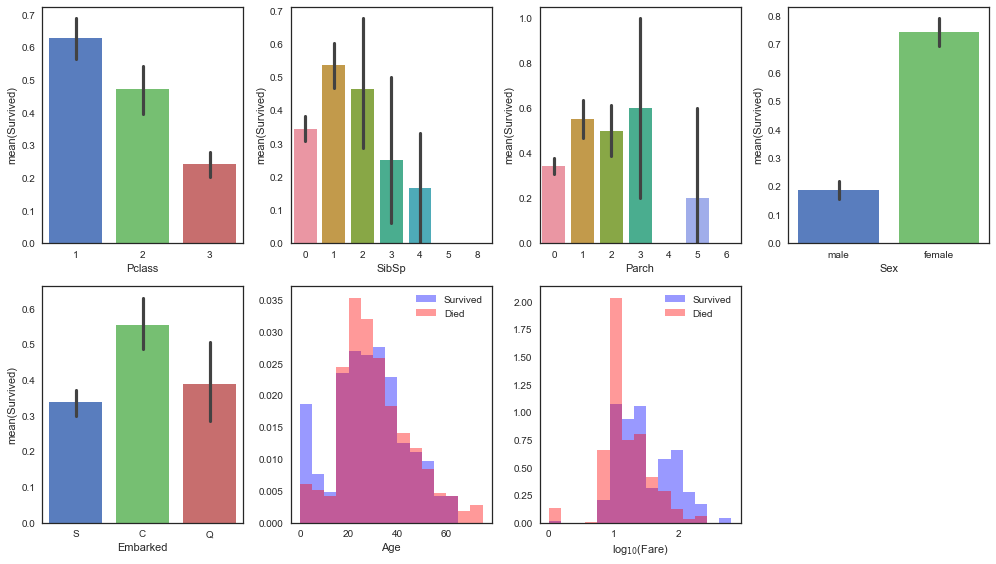

In [228]:
f = plt.figure(figsize=[14,8])
f.add_subplot(241)
sns.barplot('Pclass', 'Survived', data=train)
f.add_subplot(242)
sns.barplot('SibSp', 'Survived', data=train)
f.add_subplot(243)
sns.barplot('Parch', 'Survived', data=train)
f.add_subplot(244)
sns.barplot('Sex', 'Survived', data=train)
f.add_subplot(245)
sns.barplot('Embarked', 'Survived', data=train)
f.add_subplot(246)
sns.distplot(surv['Age'].dropna().values, bins=range(0, 80, 5), kde=False, color='blue', norm_hist=True,
            label='Survived')
sns.distplot(nsurv['Age'].dropna().values, bins=range(0, 80, 5), kde=False, color='red', norm_hist=True,
             axlabel='Age', label='Died')
plt.legend()
f.add_subplot(247)
sns.distplot(np.log10(surv['Fare'].dropna().values+1), bins=np.arange(0,3,.1875), kde=False, color='blue',
             norm_hist=True, label='Survived')
sns.distplot(np.log10(nsurv['Fare'].dropna().values+1), bins=np.arange(0,3,.1875), kde=False, color='red',
             norm_hist=True,axlabel=r'log$_{10}$(Fare)', label='Died')
plt.legend()
plt.tight_layout()

Let's look at these one by one.  

* There is a clear correlation between survival probability and Pclass, where passengers in first class are almost thrice as likely to have survived than those in third class.  This will absolutely be a useful feature for our ML model.
* Moving on to SibSp, it appears as those with 1 or 2 siblings or spouses are more likely to survive than those with 0, 3, or 4.  Those with SibSp = 1 could well be primarily married women (with their husband on board), as married women were unlikely to be traveling trans-Atlantic alone.  Similarly, those with SibSp = 0 are likely single men. As we'll see in the Sex plot, women were far more likely to survive than men.  Addtionally, SibSp >= 2 are certainly children, who were more likely to survive (as evidenced by the spike near zero in the Age histogram).  However, then we need to ask the question, "Why were those with SibSp = 3 or SibSp = 4 even less likely to survive?  It could be because large families were forced to buy more tickets, and thus chose cheaper fares - and we've already seen that Pclass correlates strongly with survival rate.  This feature needs further investigation, to be sure.
* Parch can have similar arguments made - large families (Parch = 5) were more likely to be in lower classes, and thus less likely to survive.  What about the low survival rate of Parch = 0?  These were either people traveling alone (which were probably mostly men) or couples with no children (and we know from history that women and children boarded the lifeboats first, so those without children were less likely to survive). This also requires more investigation.
* Sex is an easy one.  Women and children boarded the lifeboats first, meaning men were more than three times more likely to die.
* Embarkation is a tricky one. Those embarking in Cherbourg were 75% more likely to survive than those embarking at Southampton, and Queenstown fell somewhere in the middle.  There isn't an obvious reason for this to be true, unless the port of embarkation correlations with another variable (e.g., those embarking in Cherbourg were more likely to be in first class).
* Two things stand out to me in Age.  First, the spike near 0 for survived passengers, which is easily explained by children getting priority in lifeboats.  Similarly, there is an excess of dead passengers between about 20 and 35.  Perhaps these were young men traveling alone?
* Finally, Fare - this is mostly as expected.  Those with more expensive fares were more likely to survive.  There is a clear spike of dead passengers around 1, which are likely those in third class, while the sharp drop off in dead passengers at higher fares reflects the first class passengers being almost three times as likely to survive.

Let's explore SibSp more. First, let's check if there is an excess of men traveling alone, and an excess of women traveling with a single sibling/spouse.

In [229]:
fr_m = len(train[train['Sex'] == 'male']) / len(train)
fr_sibsp0_m = len(train[(train['SibSp'] == 0) & (train['Sex'] == 'male')]) / len(train[train['SibSp'] == 0])
fr_sibsp1_f = len(train[(train['SibSp'] == 0) & (train['Sex'] == 'female')]) / len(train[train['SibSp'] == 1])
print("Fraction of all passengers that are male: %.03f" % fr_m)
print("Fraction of SibSp = 0 passengers that are male: %.03f" % fr_sibsp0_m)
print("Fraction of all passengers that are female: %.03f" % (1-fr_m))
print("Fraction of SibSp = 1 passengers that are female: %.03f" % fr_sibsp1_f)

Fraction of all passengers that are male: 0.648
Fraction of SibSp = 0 passengers that are male: 0.714
Fraction of all passengers that are female: 0.352
Fraction of SibSp = 1 passengers that are female: 0.833


As we expected, passengers with SibSp = 0 are more likely to be male than passengers in general - although not by as much as I'd expected!  However, passengers with SibSp = 1 were more than twice as likely to be femaile than passengers in general.  This suggests that we may be onto something in suggesting that the low survival of SibSp = 0 is due to that population being predominantly men, while the high survival of SibSp = 1 is due to it being primarily women.

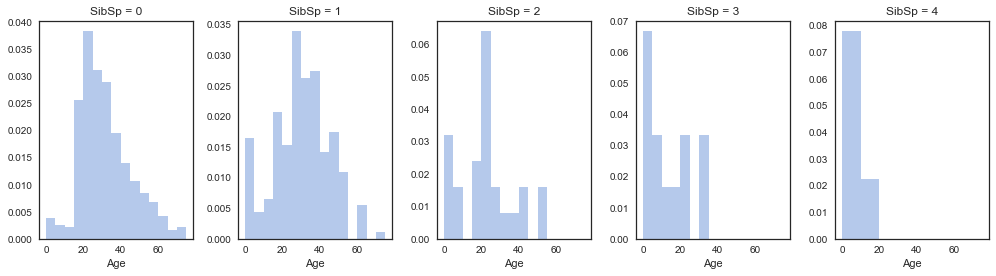

In [230]:
f = p.figure(figsize=[14,4])
for i in range(5):
    f.add_subplot(1,5,i+1)
    sns.distplot(train[train['SibSp'] == i]['Age'].dropna().values, range(0, 80, 5), kde=False, norm_hist=True,
                axlabel='Age')
    p.title('SibSp = %i' % i)
p.tight_layout()

Again, it looks like we were probably onto something in our above analysis of SibSp.  SibSp = 0 has a small number of passengers with Age < ~20 (only children), and then a steep jump up at Age = ~20, suggesting these are mostly adults.  SibSp = 1 looks similar (adults with a spouse on board), but with more children (likely since having only a single child was uncommon in 1912).  As SibSp increases, we see the distribution shift noticably to lower ages, as these are all children with several siblings on board.

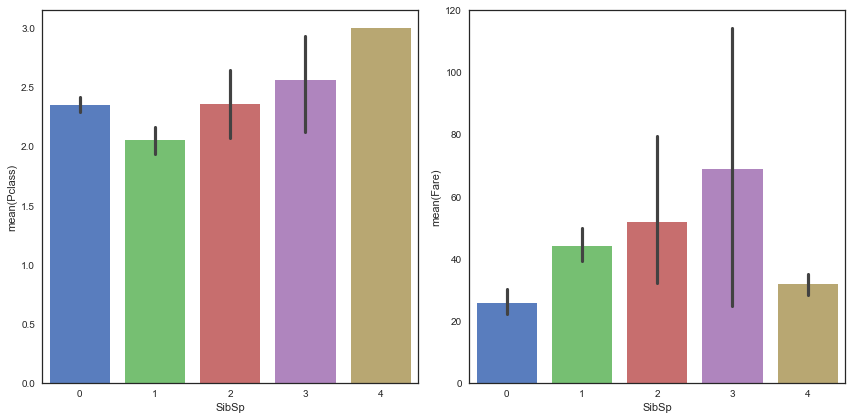

In [231]:
f = plt.figure(figsize=[12,6])
f.add_subplot(121)
sns.barplot('SibSp', 'Pclass', data=train[train['SibSp'] <= 4])
f.add_subplot(122)
sns.barplot('SibSp', 'Fare', data=train[train['SibSp'] <= 4])
plt.tight_layout()

As we surmised above, the larger the family size, the lower the class, on average.  Of course, lower classes were less likely to survive (despite the "women and children first" rule), so this is likely the reason behind the lower survival rate of SibSp > 2. Surprisingly, the mean fare increases with number of siblings, which does not reflect what is seen when looking at class.  I'm not sure what to make of this at the moment.

Now let's look more closely at Parch.

Fraction of all passengers that are male: 0.648
Fraction of Parch = 0 passengers that are male: 0.714


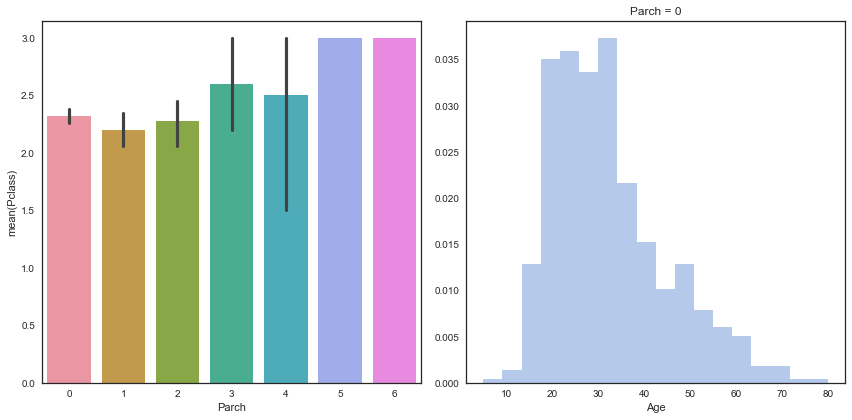

In [232]:
fr_m = len(train[train['Sex'] == 'male']) / len(train)
fr_parch0_m = len(train[(train['Parch'] == 0) & (train['Sex'] == 'male')]) / len(train[train['Parch'] == 0])
print("Fraction of all passengers that are male: %.03f" % fr_m)
print("Fraction of Parch = 0 passengers that are male: %.03f" % fr_parch0_m)

f = plt.figure(figsize=[12,6])
f.add_subplot(121)
sns.barplot('Parch', 'Pclass', data=train)
f.add_subplot(122)
sns.distplot(train['Age'][train['Parch'] == 0].dropna().values, kde=False, axlabel='Age', norm_hist=True)
plt.title('Parch = 0')
plt.tight_layout()

Let's look at embarkation next.  This is one I don't have any intuition for off the bat - my guess is that it must correlation with another feature (family size? fare class? sex?)

Fraction of passengers with Embarked = S that are male: 0.685
Fraction of passengers with Embarked = C that are male: 0.565
Fraction of passengers with Embarked = Q that are male: 0.532


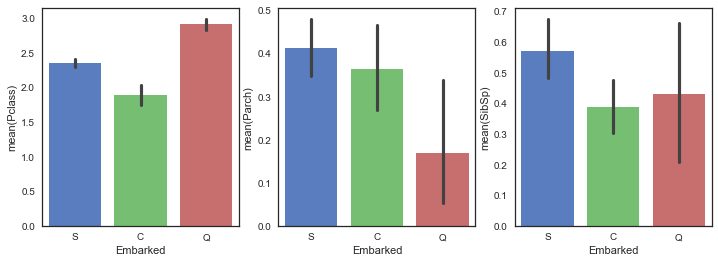

In [233]:
for port in ['S', 'C', 'Q']:
    fr = len(train[(train['Embarked'] == port) & (train['Sex'] == 'male')]) / len(train[train['Embarked'] == port])
    print( "Fraction of passengers with Embarked = %s that are male: %.03f" % (port, fr) )
f = plt.figure(figsize=[12,4])
f.add_subplot(131)
sns.barplot('Embarked', 'Pclass', data=train)
f.add_subplot(132)
sns.barplot('Embarked', 'Parch', data=train)
f.add_subplot(133)
sns.barplot('Embarked', 'SibSp', data=train)

It seems that perhaps the low survival rate of Southampton embarkations is due to the larger fraction of male passengers there.  Likewise, the high survival rate of Cherbourg passengers is reflected in the better Pclass.  Southampton also had larger family size (Parch + SibSp), which we've already seen correlates with lower survival rate.  However, it seems like Embarkation is entangled with other, more reliable features, and thus probably isn't the best predictor.

As one final exploratory measure, let's look at the correlation matrix of all of the features.  This requires a bit of data transformation (if we want to include Sex, which is currently a string).  We'll do this by simply adding a new column, SexBool, that converts Sex to a Boolean, using 0 for males and 1 for females. We've already seen that we aren't missing any data in the Sex column, so we don't need to be careful about handling missing values here.  We'll do the same with Embarked (using C=0, Q=1, S=2), being sure to deal with the two missing values when they show up (we'll just add NaN, which DataFrame.corr() ignores).

In [252]:
sex_bool = [0 if sex == 'male' else 1 for sex in train['Sex']]
train['SexBool'] = sex_bool
embarked_int = []
for e in train['Embarked']:
    if e == 'C': embarked_int.append(0)
    elif e == 'Q': embarked_int.append(1)
    elif e == 'S': embarked_int.append(2)
    else: embarked_int.append(np.nan)
train['EmbarkInt'] = embarked_int
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,SexBool,EmbarkInt
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.042939,0.013166
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351,-0.169718
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.131900,0.164681
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.093254,-0.032565
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.114631,0.068900
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.245489,0.040449
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.182333,-0.226311
SexBool,-0.042939,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,1.000000,-0.110320
EmbarkInt,0.013166,-0.169718,0.164681,-0.032565,0.068900,0.040449,-0.226311,-0.110320,1.000000


This is the most straightforward way of seeing which variables correlate with which, although it's not too informative of how those relationships actually play out - hence the analysis above.  The three variables that correlate most strongly with Survived, in descending order, are Sex, Pclass, and Fare.

We also see many of the relationships we discovered above showing up in this plot.  Pclass correlates with Age (older passengers are in higher classes) and Fare (high classes had higher higher fares), SibSp correlates with Parch (children in large families have many siblings, parents of large families have many children).  We also see Sex correlating positively with Parch and SibSp - and since we used 1 to represent women, this means that women had larger numbers of family members with them, confirming our guess that they were less likely to be traveling alone.

I think that's enough exploratory work.  We have a pretty good idea of how our features interact and influence each other, and, more importantly, which features most strongly drive survival rates. Let's build and test some ML models.

# Predictive Modeling

Import cross validation scoring package for evaluating our models.

In [328]:
from sklearn.model_selection import cross_val_score

## Naive Bayes

First, as this is a binary classification problem, let's start with a Naive Bayes model.

In [235]:
from sklearn.naive_bayes import GaussianNB

Because we'll be training on testing on the same data, we'll write a function to bootstrap a training and test set for each method.  We'll run this a handful of times, and average our results.  Addtionally, we'll frequently be averaging success rates over some number of bootstraps, so we'll include a function to do that for us.  DRY!

In [236]:
def trim_data(full_data, features):
    sdata = full_data
    for feature in features:
        sdata = full_data[np.invert(full_data[feature].isnull())]
    return sdata

def select_features(full_data, features):
    sdata = trim_data(full_data, features)
    tr_data = []
    tr_target = []
    for _, row in sdata.iterrows():
        tr_data.append(bootstrap_row(row, features))
        tr_target.append(row['Survived'])
    return tr_data, tr_target

def bootstrap_row(row, features):
    data_i = []
    for feature in features:
        try:
            data_i.append(row[feature].values[0])
        except AttributeError:
            data_i.append(row[feature])
    return data_i

def bootstrap(full_data, features):
    nsamples = len(full_data)
    sdata = trim_data(full_data, features)
    tr_data = []
    tr_target = []
    for _ in range(nsamples):
        row = sdata.sample(1)
        tr_data.append(bootstrap_row(row, features))
        tr_target.append(row['Survived'].values[0])
    return tr_data, tr_target

def multi_classify(data, y_fit, features, n_classify=10):
    ncorrs = []
    for _ in range(n_classify):
        test_data, test_target = bootstrap(data, features)
        y_pred = y_fit.predict(test_data)
        ncorrs.append( (y_pred == test_target).sum() )
    return len(test_data), np.mean(ncorrs)

To simplify matters for the time being, let's go ahead and only use the three feature that we think will best correlate with Survived - Sex, Pclass, and Fare.  We'll isolate those in an array of training data, along with the targets for them.  We'll also need to convert Sex to a Boolean for the NB classifier to handle it.  We'll use the SexBool variable we created earlier.

In [302]:
tr_data, tr_target = select_features(train, ['SexBool', 'Pclass', 'Fare', 'Age'])

We'll train our Gaussian Naive Bayes classifier on this set, and then run another XXX sets to test, and compare the predictions with the targets. Even if this logic is a bit circular, it's better than straight training and testing on the same set.

In [338]:
gnb = GaussianNB()
y_fit = gnb.fit(tr_data, tr_target)
#npass, avgcorr = multi_classify(train, y_fit, ['SexBool', 'Pclass', 'Fare'], n_classify=10)
#print("Out of %d training passengers, %.1f were predicted correctly, which is %.2f percent." %
#      (npass, avgcorr, 100*avgcorr/npass))
print(gnb.score(tr_data, tr_target))
print(cross_val_score(y_fit, tr_data, tr_target, cv=5).mean())

0.773109243697
0.766157785876


This gives us around 78%, which is better than our "requirement" of getting at least 61.6%. Could this be improved simply by adding more features? Let's expand our model by adding Parch and Embarked. Because we have two missing values for Embarked, we'll need to trim our data set to exclude those passengers.

In [339]:
tr_data, tr_target = select_features(train, ['SexBool', 'Pclass', 'Fare', 'Parch', 'EmbarkInt'])
gnb = GaussianNB()
y_fit = gnb.fit(tr_data, tr_target)
#npass, avgcorr = multi_classify(train, y_fit, ['SexBool', 'Pclass', 'Fare', 'Parch', 'EmbarkInt'], n_classify=10)
#print("Out of %d training passengers, %.1f were predicted correctly, which is %.2f percent." %
#      (npass, avgcorr, 100*avgcorr/npass))
print(gnb.score(tr_data, tr_target))
print(cross_val_score(y_fit, tr_data, tr_target, cv=5).mean())

0.784026996625
0.778429505491


This provides us with a pretty negligible increase (if any).  This should raise the question of how much predicting power the additional features give.  What if we ran a NB with just Sex?

In [340]:
tr_data, tr_target = select_features(train, ['SexBool'])
gnb = GaussianNB()
y_fit = gnb.fit(tr_data, tr_target)
#npass, avgcorr = multi_classify(train, y_fit, ['SexBool'], n_classify=10)
#print("Out of %d training passengers, %.1f were predicted correctly, which is %.2f percent." %
#      (npass, avgcorr, 100*avgcorr/npass))
print(gnb.score(tr_data, tr_target))
print(cross_val_score(y_fit, tr_data, tr_target, cv=5).mean())

0.786756453423
0.786715024929


As I suspected, Sex is driving our Naive Bayes mdoel.  In fact, I wonder what would happen if we simply predicted that all women lived and all men died.

In [307]:
strain = trim_data(train, ['Sex'])
y_pred = [1 if sex == 'female' else 0 for sex in strain['Sex']]
ncorr = (y_pred == strain['Survived']).sum()
npass = len(y_pred)
print("Out of %d training passengers, %.1f were predicted correctly, which is %.2f percent." %
      (npass, ncorr, 100*ncorr/npass))

Out of 891 training passengers, 701.0 were predicted correctly, which is 78.68 percent.


Okay, yeah. So our Naive Bayes model is really no better than predicting that a female passenger will survive and a male passenger will die. We'll need to use a different model.

## k Nearest Neighbors

Next, let's try a k Nearest Neighbors approach.

In [242]:
from sklearn.neighbors import KNeighborsClassifier

Train the model and make some predictions...

In [341]:
tr_data, tr_target = select_features(train, ['SexBool', 'Pclass', 'Fare', 'Age'])
knn = KNeighborsClassifier(n_neighbors=3)
y_fit = knn.fit(tr_data, tr_target)
#npass, avgcorr = multi_classify(train, y_fit, ['SexBool', 'Pclass', 'Fare'], n_classify=10)
#print("Out of %d training passengers, %.1f were predicted correctly, which is %.2f percent." %
#      (npass, ncorr, 100*ncorr/npass))
print(knn.score(tr_data, tr_target))
print(cross_val_score(y_fit, tr_data, tr_target, cv=5).mean())

0.830532212885
0.676529104698


This is definitely an improvement. Let's go ahead and do a simple optimization of the hyperparameters to see how well we can make our kNN perform.

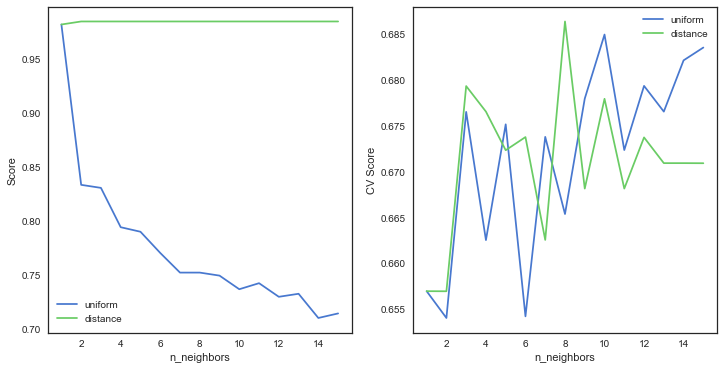

In [346]:
f = plt.figure(figsize=[12,6])
f.add_subplot(121)
n_neighbors_list = range(1,16)
for weights in ['uniform', 'distance']:
    scores = []
    for n_neighbors in n_neighbors_list:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        y_fit = knn.fit(tr_data, tr_target)
        scores.append(knn.score(tr_data, tr_target))
    plt.plot(n_neighbors_list, scores, label=weights)
    plt.legend()
    plt.xlabel('n_neighbors')
    plt.ylabel('Score')
f.add_subplot(122)
for weights in ['uniform', 'distance']:
    cv_scores = []
    for n_neighbors in n_neighbors_list:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        y_fit = knn.fit(tr_data, tr_target)
        cv_scores.append(cross_val_score(y_fit, tr_data, tr_target, cv=5).mean())
    plt.plot(n_neighbors_list, cv_scores, label=weights)
    plt.legend()
    plt.xlabel('n_neighbors')
    plt.ylabel('CV Score')

So it looks like we can do best with k=3 and weighting by distance.  Let's get that score explicitly for comparison with other models later.

In [342]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
y_fit = knn.fit(tr_data, tr_target)
print(knn.score(tr_data, tr_target))
print(cross_val_score(y_fit, tr_data, tr_target, cv=5).mean())

0.984593837535
0.679346006107


Next, let's see how we can do with a Random Forest.  I'll (arbitrarily) start with 10 estimators, and we can optimize that later.

In [351]:
from sklearn.ensemble import RandomForestClassifier
tr_data, tr_target = select_features(train, ['SexBool', 'Pclass', 'Fare', 'Age'])
rf = RandomForestClassifier(n_estimators=100)
y_fit = rf.fit(tr_data, tr_target)
#npass, avgcorr = multi_classify(train, y_fit, ['SexBool', 'Pclass', 'Fare'], n_classify=10)
#print("Out of %d training passengers, %.1f were predicted correctly, which is %.2f percent." %
#      (npass, ncorr, 100*ncorr/npass))
print(rf.score(tr_data, tr_target))
print(cross_val_score(y_fit, tr_data, tr_target, cv=5).mean())

0.984593837535
0.801181916675


This is roughly the same as kNN, so at least it's competitive.  Let's optimize the number of estimators.

Max score of 0.984594 with 35 estimators


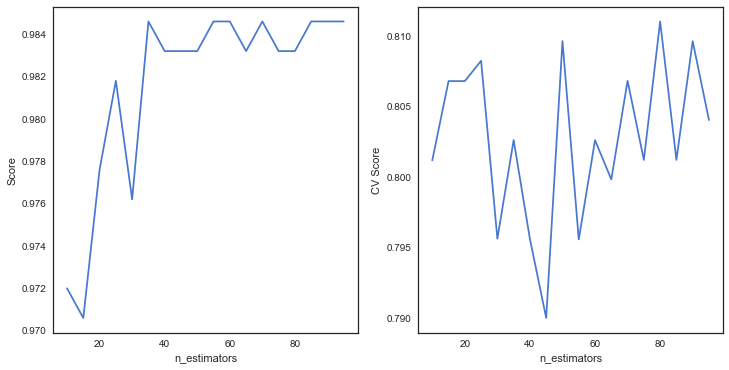

In [348]:
f = plt.figure(figsize=[12,6])
f.add_subplot(121)
n_estimators_list = range(10,100,5)
scores = []
cv_scores = []
for n_estimators in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_estimators)
    y_fit = rf.fit(tr_data, tr_target)
    scores.append(rf.score(tr_data, tr_target))
    cv_scores.append(cross_val_score(y_fit, tr_data, tr_target, cv=5).mean())
plt.plot(n_estimators_list, scores)
plt.xlabel('n_estimators')
plt.ylabel('Score')
f.add_subplot(122)
plt.plot(n_estimators_list, cv_scores)
plt.xlabel('n_estimators')
plt.ylabel('CV Score')
print("Max score of %f with %i estimators" % (max(scores), n_estimators_list[np.array(scores).argmax()]))

So, it appears we can max ourselves out, score-wise, with 80 estimators.  In fact, this gives us the same performance as kNN.